In [1]:
import jax
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import jax.numpy as jnp
from project_imports_2 import shared
from project_imports_2.shared_functions import *

from Shared.shared import *
from Shared.specific_CNB_sim import *
from Shared.specific_CNB_decay import *
from scipy import integrate
################
### Controls ###
################
INT_STEPS_2FLAVOR = 100

In [18]:

"""Starting parameters: gamma value, mass of heavy neutrino, mass of light neutrino, initial momentum, final momentum,
z_dec, z_here, number of neutrinos"""              

def SPEC_n_prefactor(p_array, z_array):
   return p_array**2/(2*np.pi**2*(1+z_array)**3) *(1/(np.exp(p_array/(T_CNB*(1+z_array))) + 1))

def Xi(z_end, z_array, p_array, m, int_steps=100):
    """Auxiliary integral, representing effective time between z_end and z."""

    # Integrand in xi function
    def integrand(z_array, p_array, m):
        p_array = p_array.T #necessary operations for broadcasting arrays with different sizes
        z_array= z_array.T
        factor_1 = 1/(CALC_Hubble_rate(z_array)*(1+z_array))
        factor_2 = 1/np.sqrt(np.square(1+z_array[:,:, np.newaxis]) + np.square(m/p_array[:, np.newaxis]) )
        integrand = factor_1[:,:,np.newaxis]*factor_2
        return integrand.T
    
    # Create redshift integration range.
    z_int_range = np.logspace(np.log10(z_array+1), np.log10(z_end+1), int_steps)-1 #integration range for each new z as given in the input variables
    integrand_array = integrand(z_int_range, p_array, m) #array of integrands in order to integrate in Xi_array
    Xi_array = np.trapz(integrand_array, x=z_int_range[np.newaxis,:,:], axis=1)
 

    return Xi_array  

def n3_p_range(p_array, z_array, z_end, Gamma, m): 
    """Number density for m_3 per momentum range, prefactor, xi_factor and decay probability."""
    # Prefactor
    n_pre = SPEC_n_prefactor(p_array,z_array)
    
    # Exp-factor with Xi integral.
    Xi_factor = Xi(z_end, z_array, p_array/(1+z_array), m)
    n_exp = np.exp(-((m*Gamma*(1+z_array)* Xi_factor)/p_array) )
    print(Xi_factor)
    n3_deriv_p_range = n_pre * n_exp  * (-3 / (1 + z_array)+ 
                  (p_array / (T_CNB * (1 + z_array) ** 2)) * 1/(np.exp(p_array/(T_CNB*(1+z_array))) + 1) *np.exp(p_array / (T_CNB * (1 + z_array))) - 
                  (Gamma * m / p_array) * (Xi_factor -((1+z_array)/(CALC_Hubble_rate_2(z_array)))* (1/(np.sqrt((1+z_array)**2 + (m**2/p_array**2) )))))
  
    #n3_deriv_p_range = n_pre * n_exp  * (3 / (1 + z_array) + 
    #              (p_array / (T_CNB * (1 + z_array) ** 2)) * 1/(np.exp(p_array/(T_CNB*(1+z_array))) + 1) *np.exp(p_array / (T_CNB * (1 + z_array))) + 
    #              (Gamma * m / p_array)*(1+z_array) * (Xi_factor/(1+z_array) + 1/(CALC_Hubble_rate_2(z_array)) * (1/(np.sqrt((1+z_array)**2 + (m**2/p_array**2) )))))

    
    return n_pre * n_exp, n_pre, Xi_factor, (n3_deriv_p_range)

def redshift_distance(p0, m, z_array, int_steps = INT_STEPS_2FLAVOR):
    z_final = np.zeros(np.shape(z_array)) #final redshift, so our redshift z=0
    z_initial = z_array #array of possitble initial redshifts
    def integrand(z_array):
        H_z = CALC_Hubble_rate(z_array)
        denominator =   H_z*np.sqrt(p0**2+ m**2/(1+z_array)**2)
        return (p0/denominator)
    
    z_range_2=np.logspace(np.log10(z_final+1), np.log10(z_initial+1),int_steps) - 1 #define an integration range
    # Calculate the integrand values
    integrand_values = integrand(z_range_2)
    # Perform the numerical integration using np.trapz
    distance = np.trapz(integrand_values, z_range_2, axis = 0)
    distance = distance[-1]-distance #Correct values
    return distance



def montecarlo_1(number_simulations, p0,m,Gamma_val,z_dec,z_steps):
   # z_array = np.logspace(np.log10(0+1), np.log10(z_dec+1), z_steps)-1 #array of redshifts for testing # neutrino decays at each point
    z_array= [0, 0.0038223239895366357, 0.007790749585883147, 0.011910861265805747, 0.016188456962865708, 0.02062955622642977, 0.02524040869254421, 0.03002750287859307, 0.03499757531411696, 0.040157620020641244, 0.04551489835385383, 0.05107694922198308, 0.056851599694755006, 0.0628469760178596, 0.06907151504842529, 0.07553397612759427, 0.08224345340690684, 0.08920938864583905, 0.09644158449850457, 0.10395021830821685, 0.11174585642932416, 0.11983946909647203, 0.12824244586221653, 0.1369666116247132, 0.14602424326803673, 0.1554280869385469, 0.16519137598161346, 0.175327849563941, 0.1858517720076989, 0.19677795286366476, 0.2081217677516284, 0.21989917999738326, 0.23212676309675426, 0.244821724038273, 0.25800192751732176, 0.27168592107582, 0.28589296120283125, 0.3006430404328204, 0.3159569154796932, 0.33185613644621015, 0.3483630771498797, 0.36550096660800413, 0.3832939217261868, 0.4017669812362995, 0.4209461409316684, 0.4408583902490648, 0.46153175024897664, 0.48299531304760823, 0.5052792827561012, 0.528415017984583, 0.5524350759708586, 0.5773732583958445, 0.6032646589502149, 0.630145712719202, 0.6580542474550415, 0.687029536809217, 0.7171123555994148, 0.7483450371889591, 0.7807715330594762, 0.8144374746606183, 0.8493902376238842, 0.8856790084309009, 0.9233548536299822, 0.9624707916983682, 1.0030818676512752, 1.0452452305027389, 1.0890202136872689, 1.1344684185554774, 1.1816538010611768, 1.2306427617619466, 1.2815042392598066, 1.3343098072134996, 1.3891337750588981, 1.4460532925792675, 1.5051484584725454, 1.5665024330684194, 1.6302015553538058, 1.69633546447143, 1.7649972258624762, 1.83628346223081, 1.9102944895130896, 1.9871344580460817, 2.066911499129862, 2.1497378771931315, 2.235730147774776, 2.3250093215440115, 2.417701034589889, 2.5139357252198296, 2.613848817515976, 2.7175809119076466, 2.825277983028097, 2.937091585134014, 3.0531790653767907, 3.173703785225734, 3.2988353503547874, 3.4287498493162487, 3.5636301013374028, 3.7036659135887087, 3.849054348285637, 3.9999999999999996]
    z_array =np.array(z_array)
    #z_array = np.logspace(np.log10(0+1), np.log10(1e4+1), 100)-1 
    distances_arr = redshift_distance(p0, m, z_array) #translation into distance
   
    p_range = np.linspace(0.01, 400, 10000) * T_CNB 
    redshifted_p_range = p_range[:, np.newaxis] * (1 + z_array) #using broadcasting methods to multiple z_arr and p_range
    n3_raw, prefac, xi, decay_prob = n3_p_range(p_array=redshifted_p_range, z_array=z_array, z_end=z_array[-1], Gamma=Gamma_val, m=m) #obtain values fro the decay probability
     
   # prob_dec = np.trapz(decay_prob, redshifted_p_range, axis=0)/np.array(np.trapz(decay_prob, redshifted_p_range, axis=0))[-1]
    n3_deriv_redshifts = np.trapz(decay_prob, redshifted_p_range,axis=0)

    plt.semilogx(1+z_array, n3_deriv_redshifts/(1/cm**3))
    
    plt.show()
   
    n3_redshifts = np.trapz(n3_raw, redshifted_p_range, axis=0)

    n3_initial = n3_redshifts [-1]
    prob_dec = (n3_deriv_redshifts) /(n3_initial)
    prob_dec_max = np.max(prob_dec)
    prob_dec = prob_dec/prob_dec_max
    
   # integrated_distribution =  n3_redshifts
    integrated_distribution =  n3_redshifts/n3_initial
   
    prob_surv = 1 -  prob_dec  # Calculate the probability of survival and decay
    plt.plot(1+z_array, n3_redshifts/(1/cm**3), label=rf'$\tau ={(1/Gamma_val)/s:.2g}s, m={m}eV$')
    plt.xlabel('1+z')
    plt.ylabel(r'$n_3$ cm$^{-3}$')
    plt.xlim(5,1)
    plt.title('Number density as a function of redshift')
    plt.legend()
    plt.grid()
    plt.show()
   
    #plt.plot(z_array, prob_dec)
    #plt.show()
    
    random_numbers = np.random.rand(number_simulations) #random numbers between 0 and 1
    occurences_redshifts = (z_array)[np.searchsorted(integrated_distribution[:-1], random_numbers)]
     
    print(prob_dec_max)
    #plt.figure(figsize=(10, 5))
    
    plt.xscale('linear')
    plt.grid()
    plt.yscale('linear')
   # plt.hist(np.log10(occurences_redshifts+1),histtype='step',bins=50,color='mediumpurple')
    histogram_data, bins, bars = plt.hist((np.log10(1+occurences_redshifts[occurences_redshifts != 0])),bins=100,histtype='step',color='mediumpurple', label=rf'$\tau ={1/Gamma_val:.2g}s, m={m}eV$, $N_{{init}}=768000$')
    plt.xlabel('log(1+z)')
    
    plt.legend()
    plt.ylabel('Number of decayed neutrinos')
    plt.title('Number of decayed neutrinos as a function of redshift')
    plt.show()

   # width = np.diff(bins)
  #  center = (bins[:-1] + bins[1:]) / 2
# Plot histogram-style using plt.plot()
    #plt.plot(center, histogram_data/np.max(histogram_data), linestyle='-', marker='o')
    #plt.plot(np.log10(1+z_array), prob_dec)
# Add labels and title
    #plt.xlabel('Value')
   # plt.ylabel('Frequency')
   # plt.title('Histogram-style Plot')
# Show plot
  #  plt.show()
    # plt.hist(E, bins=50,holcolor='mediumpurple')

    #histogram_data /= 768000

# Now you can plot the histogram with the modified data
  
   
    #plt.semilogx(np.log10(1+z_array), prob_dec) 
    return z_array,histogram_data



[[2.11483925e+28 2.10158260e+28 2.08795214e+28 ... 1.99246525e+26
  9.76868043e+25 0.00000000e+00]
 [1.05748304e+29 1.05085432e+29 1.04403867e+29 ... 9.96292184e+26
  4.88463220e+26 0.00000000e+00]
 [1.90348199e+29 1.89155021e+29 1.87928197e+29 ... 1.79333697e+27
  8.79239191e+26 0.00000000e+00]
 ...
 [4.09986537e+32 4.06454404e+32 4.02830514e+32 ... 1.44693847e+30
  6.98729087e+29 0.00000000e+00]
 [4.09998307e+32 4.06466017e+32 4.02841967e+32 ... 1.44694325e+30
  6.98731323e+29 0.00000000e+00]
 [4.10010074e+32 4.06477628e+32 4.02853417e+32 ... 1.44694802e+30
  6.98733558e+29 0.00000000e+00]]


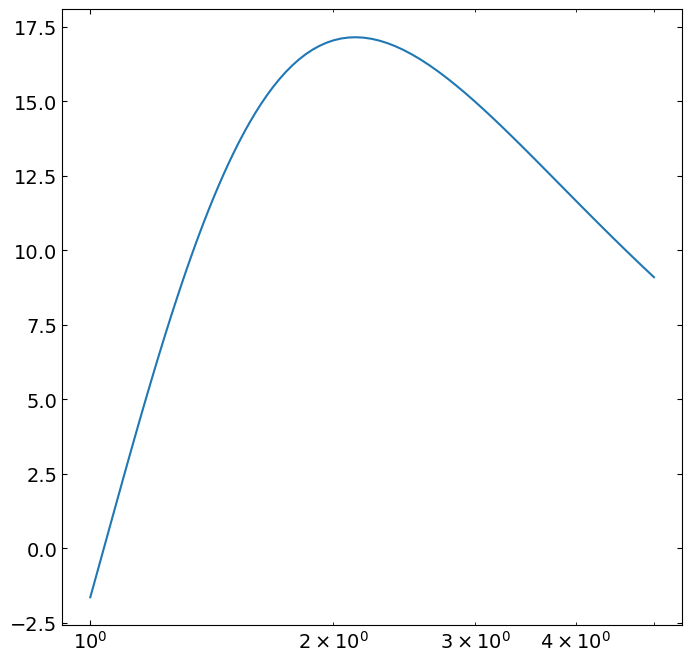

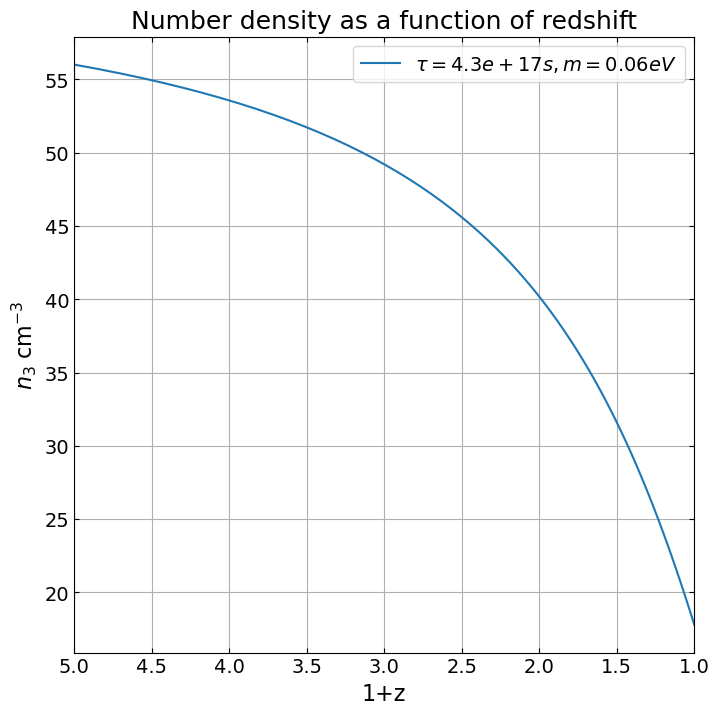

0.3062414008002585


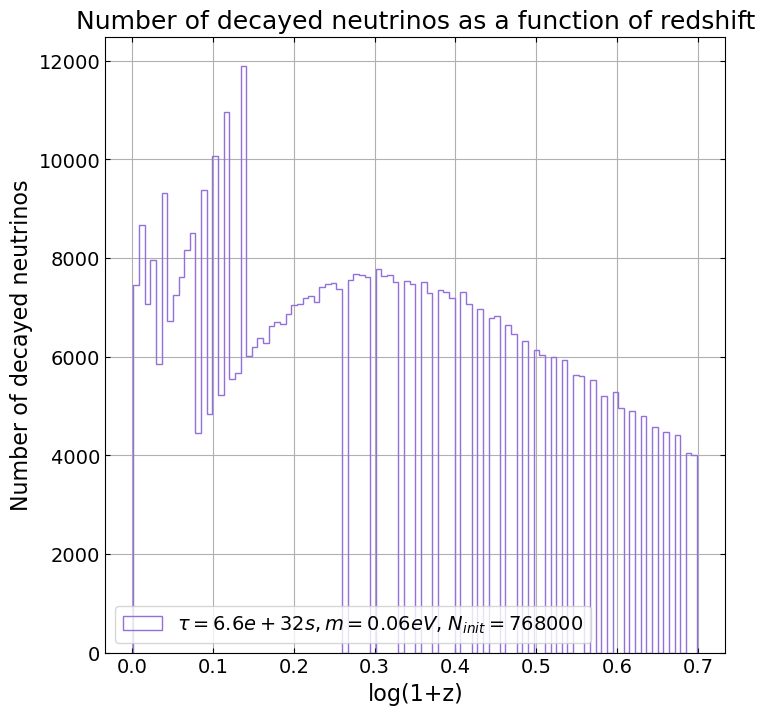

524327.0

In [19]:
Gamma_val =(1/(Params.t0/s))/s
z_array, histogram_data = montecarlo_1(number_simulations = 768000, p0 = 3*T_CNB,  m = 0.06*eV,Gamma_val = Gamma_val, z_dec = 4, z_steps =100)
np.sum(histogram_data)

In [10]:
# Calculate the total number of neutrinos
total_neutrinos = 768000
gamma ='2T'
# Create an array representing individual neutrinos (all ones)
neutrinos_array = np.ones(total_neutrinos)

# List to store neutrinos_array for each redshift step
nose = []
neutrinos_decayed_index =[]
neutrinos_decayed_theta =[]
neutrinos_decayed_phi = []
otromos =[]
# Iterate over redshift steps
for i, num_decayed in enumerate(histogram_data):
  
    # Reset decayed indices
    decay_indices = []
    neutrinos_decayed_index_0 =[]
    # Randomly select neutrinos to decay
    while len(decay_indices) < num_decayed:
        index = np.random.randint(total_neutrinos)
        if neutrinos_array[index] == 1:  # Check if neutrino is still active
            decay_indices.append(index)
            theta = np.random.randint(0,180)
            phi = np.random.randint(0,360)    
            neutrinos_decayed_theta.append(theta)
            neutrinos_decayed_phi.append(phi)
            otromos.append(index)
            neutrinos_decayed_index_0.append(index)
            neutrinos_array[index] = 0
    
    # Append a copy of neutrinos_array to nose for each redshift step
   
    neutrinos_decayed_index.append(np.array(neutrinos_decayed_index_0))
    nose.append(np.copy(neutrinos_array)) 

print(np.size(neutrinos_decayed_theta))
print(np.shape(neutrinos_decayed_phi))
neutrinos_decayed_index_array = np.empty(len(neutrinos_decayed_index), dtype=object)
neutrinos_decayed_index_array[:] = neutrinos_decayed_index
np.save(f"decayed_neutrinos_z_{gamma}.npy",nose)
np.save(f'decayed_neutrinos_index_z_{gamma}.npy', neutrinos_decayed_index_array)

np.save(f"decayed_neutrinos_theta_{gamma}.npy",neutrinos_decayed_theta)
np.save(f"decayed_neutrinos_phi_{gamma}.npy",neutrinos_decayed_phi)



334785
(334785,)


In [5]:
neutrinos_decayed_index_array = np.empty(len(neutrinos_decayed_index), dtype=object)
neutrinos_decayed_index_array[:] = neutrinos_decayed_index
# Save the object array to a file
np.save('decayed_neutrinos_index_z_0.5T.npy', neutrinos_decayed_index_array)
result_array = np.concatenate([arr for arr in  neutrinos_decayed_index_array if arr.size > 0])

In [ ]:
def Fermi_Dirac(p):
    """Fermi-Dirac phase-space distribution for CNB neutrinos. 
    Zero chem. potential and temp. T_CNB (CNB temp. today). 

    Args:
        p (array): magnitude of momentum, must be number_density(p0, p1, pix_sr=4*Pi) in eV!

    Returns:
        array: Value of Fermi-Dirac distr. at p.
    """

    # Function expit from scipy equivalent to 1/(np.exp(-X)+1).
    # (thus the minus sign)
    return expit(-p/T_CNB) 


def velocity_to_momentum(sim_vels, m_arr):
    """
    Converts velocities (x,y,z from simulation) to 
    magnitude of momentum [eV] and ratio y=p/T_nu, according to desired
    target mass (and mass used in simulation).
    """

    # Magnitudes of velocity.
    mags_sim = np.sqrt(np.sum(sim_vels**2, axis=-1))
    mags_dim = np.repeat(np.expand_dims(mags_sim, axis=0), len(m_arr), axis=0)

    # Adjust neutrino target mass array dimensionally.
    m_dim = np.expand_dims(
        np.repeat(
            np.expand_dims(m_arr, axis=1), mags_dim.shape[1], axis=1),
        axis=2
    )
      # From velocity (magnitude) in kpc/s to momentum in eV.
    # p_dim = 1/np.sqrt(1-mags_dim**2) * mags_dim*(kpc/s) * m_dim
    p_dim = mags_dim*(kpc/s) * m_dim

    # p/T_CNB ratio.
    y = p_dim/T_CNB
     
    return p_dim, y
    

In [ ]:
def theta(v_arr_p,v_arr_d):
    cos_theta = (np.dot(v_arr_p,v_arr_d))/(np.linalg.norm(v_arr_p)*np.linalg.norm(v_arr_d))
    angle = np.arccos(cos_theta)
    return angle

In [ ]:
def number_density(p_init, p_back, pix_sr):
      
    """Neutrino number density obtained by integration over initial momenta.

    Args:
        p_init (array): neutrino momentum today
        p_back (array): neutrino momentum at z_back (final redshift in sim.)

    Returns:
        array: Value of relic neutrino number density in (1/cm^3).
    """    

    # note: trapz integral method needs sorted (ascending) "x-axis" array.
    ind = p_init.argsort(axis=-1)
    p_init_sort = jnp.take_along_axis(p_init, ind, axis=-1)
    p_back_sort = jnp.take_along_axis(p_back, ind, axis=-1)

    non_zero_mask_init = p_init_sort != 0
    non_zero_elements_init = p_init_sort[non_zero_mask_init]
    p_init_sort = non_zero_elements_init.reshape(p_init_sort.shape[0], -1)
  
    non_zero_mask_back= p_back_sort != 0
    non_zero_elements_back = p_back_sort[non_zero_mask_back]
    p_back_sort = non_zero_elements_back.reshape(p_back_sort.shape[0], -1)
    # Fermi-Dirac values with momenta at end of sim
    FD_arr = Fermi_Dirac(p_back_sort)
   
    # Calculate number density
    y = p_init_sort**3 * FD_arr  # dlog integrand
    x = p_init_sort
 
    n_raw = np.trapz(y, np.log(x), axis=-1)

    # Multiply by constants and/or solid angles and convert to 1/cm**3.
    n_cm3 = pix_sr * 1/((2*Pi)**3) * n_raw / (1/cm**3)
    
    return jnp.array(n_cm3)

In [ ]:
m_arr=[0.01, 0.010718779370383411, 0.011489223119095704, 0.012315044775069516, 0.013200224788036322, 0.014149029714242745, 0.01516603278119671, 0.01625613593056498, 0.017424593445468855, 0.018677037276060956, 0.02001950418545241, 0.021458464846833177, 0.023000855032033318, 0.02465410904185382, 0.026426195539300583, 0.02832565595843733, 0.0303616456739876, 0.0325439781301229, 0.03488317214113704, 0.03739050259199532, 0.040078054783134684, 0.042958782681456024, 0.04604657135827752, 0.05, 0.05290393322046121, 0.056706558801562126, 0.06078250926476182, 0.06515143063872675, 0.069834381068135, 0.07485393231366196, 0.08023427854757563, 0.08600135296933499, 0.092182952803277, 0.1, 0.10591105125339181, 0.11352371912704769, 0.12168356986281993, 0.13042993383602033, 0.1398049684082008, 0.14985386112509277, 0.1606250475199945, 0.17217044457241729, 0.1845457009472567, 0.2, 0.21202867338529435, 0.22726885702120553, 0.2436044736169516, 0.261114260633849, 0.27988261501950196, 0.3]

In [ ]:
number_density_parent =[]
number_density_daughter=[]

In [98]:
#gamma_array =['0.1T','0.5T','T','2T']
gamma_array =['2T']
number_density_parent =[]
number_density_daughter=[]
number_density_nodecay =[]

for gamma in gamma_array:
    nu_vectors_p = np.load(f'vectors_halo1_p_{gamma}.npy')
    nu_vectors_nd =np.load(f'vectors_halo1_nd.npy')
    nu_vectors_d =np.load(f'vectors_halo1_d_{gamma}.npy')
    
    v_arr_nd=nu_vectors_nd.reshape(-1, 2, 6)[..., 3:]
    p_arr_nd, _ = velocity_to_momentum(v_arr_nd, m_arr)
    n_cm3_nd = number_density(p_arr_nd[...,0], p_arr_nd[...,-1],  pix_sr=4*Pi)
    
    v_arr_p=nu_vectors_p.reshape(-1, 2, 6)[..., 3:]
    p_arr_p, _ = velocity_to_momentum(v_arr_p, m_arr)
    n_cm3_p = number_density(p_arr_p[...,0], p_arr_p[...,-1],  pix_sr=4*Pi)
   
    v_arr_d=nu_vectors_d.reshape(-1, 2, 6)[..., 3:]
    p_arr_d, _ = velocity_to_momentum(v_arr_d, m_arr)
    n_cm3_d = number_density(p_arr_d[...,0], p_arr_d[...,-1],  pix_sr=4*Pi)
    
    angle = theta(nu_vectors_d[2,1,0,3:6],nu_vectors_d[2,1,1,3:6])
    print(nu_vectors_d[:,1,0,3:6] == nu_vectors_d[:,1,1,3:6])
    #print(nu_vectors_d[10,1,1,3:6])
    #print(nu_vectors_d[543,1,0,3:6])
    #print(nu_vectors_d[543,1,1,3:6])
    print(angle*180/np.pi)
    if np.size(p_arr_p[p_arr_p!=0])>np.size(p_arr_d[p_arr_d!=0]):
        number_density_parent.append(n_cm3_p[23])
        number_density_daughter.append(n_cm3_nd[23]-n_cm3_p[23])
        number_density_nodecay.append(n_cm3_nd[23])
        
    elif np.size(p_arr_d[p_arr_d!=0])>np.size(p_arr_p[p_arr_p!=0]):
        number_density_parent.append(n_cm3_nd[23]-n_cm3_d[23])
        number_density_daughter.append(n_cm3_d[23])
        number_density_nodecay.append(n_cm3_nd[23])
        

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x12fa613d0>> (for pre_run_cell):


TypeError: pre_run_cell() takes 1 positional argument but 2 were given

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 ...
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]]
8.537736462515939e-07


[ True  True  True  True]


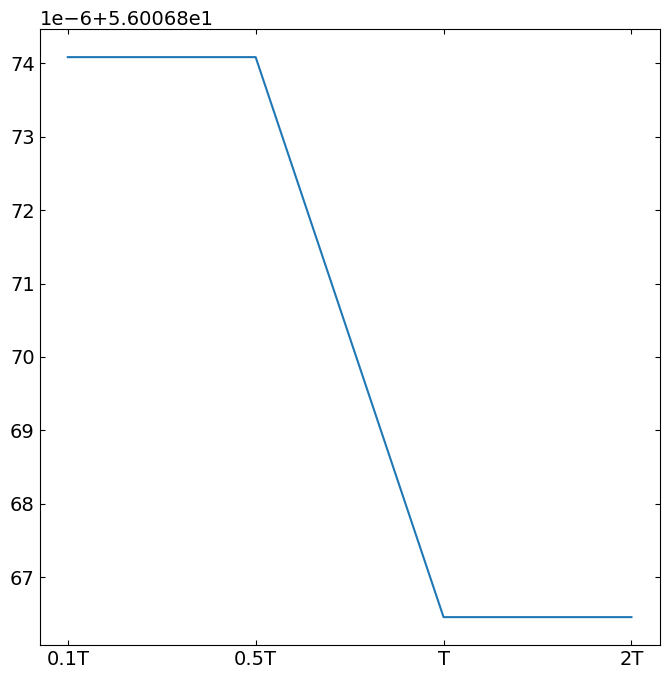

In [ ]:
#plt.scatter(gamma_array,number_density_nodecay)
#plt.scatter(gamma_array,number_density_parent)
plt.plot(gamma_array,np.array(number_density_nodecay) - np.array(number_density_parent))
print(np.array(number_density_nodecay) >= np.array(number_density_parent))

In [ ]:
import jax
import jax.random as random
from scipy.optimize import fsolve
from scipy.optimize import minimize


In [ ]:
key = jax.random.PRNGKey(0)

In [ ]:
key = jax.random.PRNGKey(0)
key, subkey_theta, subkey_phi = random.split(key, 3)
angle_decay_theta = random.randint(subkey_theta,(1,), 0, 179)
angle_decay_phi = random.randint(subkey_phi,(1,), 0, 360)
print(angle_decay_theta)
print(angle_decay_phi )

[17]
[185]


In [ ]:
pip install healpy

/Users/mariahernandezsanz/anaconda3/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from shared import *
import jax.random as random
from scipy.optimize import fsolve
from scipy.optimize import minimize

class decay():
    @jax.jit
    def SPEC_n_prefactor(p, z, args):
        '''z and p are both arrays'''
        # Assuming T_CNB is passed as an argument
        return p**2 / (2*jnp.pi**2 * (1+z)**3) * (1 / (jnp.exp(p / (args.T_CNB * (1+z))) + 1))

    @jax.jit
    def CALC_Hubble_rate(z, args):
        # Hubble rate in "numerical" units.
        return args.H0*jnp.sqrt(args.Omega_R*(1+z)**4 + args.Omega_M*(1+z)**3)
    def CALC_Hubble_rate_2(z, args):
        # Hubble rate in "numerical" units.
        return args.H0*jnp.sqrt(args.Omega_R*(1+z)**6+ args.Omega_M*(1+z)**5+ args.Omega_L*(1+z)**2)
    def integrand_rd(p0,m,z):
        H_z = decay.CALC_Hubble_rate(z)
        denominator =   H_z*jnp.sqrt(p0**2+ m**2/(1+z)**2)
        return (p0/denominator)
    
    def redshift_distance(p0, m, z, int_steps = 100):
        z_final = jnp.zeros(jnp.shape(z)) #final redshift, so our redshift z=0
        z_initial = z #array of possitble initial redshifts
        z_range_2=jnp.logspace(jnp.log10(z_final+1), jnp.log10(z_initial+1),int_steps) - 1 #define an integration range

        # Calculate the integrand values
        integrand_values = decay.integrand_rd(p0,m, z_range_2)
        # Perform the numerical integration using np.trapz
        distance = np.trapz(integrand_values, z_range_2, axis = 0)
        distance = distance[-1]-distance #Correct values
        return distance
    
    def integrand(z, redshifted_p,  m_h, args):
        p = redshifted_p.T  # necessary operations for broadcasting arrays with different sizes
        z = z.T
        factor_1 = 1 / (decay.CALC_Hubble_rate(z, args=args) * (1 + z))
        factor_2 = 1 / jnp.sqrt(jnp.square(1 + z[:, :, jnp.newaxis]) + jnp.square(m_h/ p[:, jnp.newaxis]))
        integrand = factor_1[:, :, jnp.newaxis] * factor_2
        return integrand.T

    def Xi(z, redshifted_p, m_h, args):
        """Auxiliary integral, representing effective time between z_end and z where z is an array."""
        int_steps = 100
        
        # Integrand in xi function
        # Create redshift integration range.
        z_int_range = jnp.logspace(jnp.log10(z + 1), jnp.log10(z[-1] + 1), int_steps) - 1  # integration range for each new z as given in the input variables
        integrand_array = decay.integrand(z_int_range, redshifted_p, m_h,args=args)  # array of integrands in order to integrate in Xi_array
        Xi_array =jax.scipy.integrate.trapezoid(integrand_array, x=z_int_range[jnp.newaxis, :, :], axis=1)
        return Xi_array    

    #@jax.jit
    def n3_p_range(p, z , Gamma, m_h, args): 
        '''gamma, z_end, m passed on as args'''
        """Number density for m_3 per momentum range, prefactor, xi_factor and decay probability."""
        # Prefactor
        n_pre = decay.SPEC_n_prefactor(p,z,args = args)

        # Exp-factor with Xi integral.
        Xi_factor = decay.Xi(z, p/(1+z),m_h, args = args)
        
        n_exp = jnp.exp(-((m_h*Gamma*(1+z)* Xi_factor)/p) )
        n3_deriv_p_range = n_pre * n_exp  * (-3 / (1 + z)+ 
                    (p / (args.T_CNB * (1 + z) ** 2)) * 1/(jnp.exp(p/(args.T_CNB *(1+z))) + 1) *jnp.exp(p / (args.T_CNB  * (1 + z))) - 
                    (Gamma* m_h/ p) * (Xi_factor -((1+z)/(decay.CALC_Hubble_rate_2(z,args=args)))* (1/(jnp.sqrt((1+z)**2 + (m_h**2/p**2) )))))
        return n_pre * n_exp, n_pre, Xi_factor, jnp.abs(n3_deriv_p_range)
   
    #@jax.jit
    def decay_neutrinos(histogram_data, args):
        total_neutrinos = jnp.sum(histogram_data)

        # Create an array representing individual neutrinos (all ones)
        neutrinos_array =jnp.ones(total_neutrinos)
        key = jax.random.PRNGKey(0)
        # List to store neutrinos_array for each redshift step
        decayed_redshift = []
        neutrinos_decayed_index =[]
        #for statement 
        # Iterate over redshift steps
        for i, num_decayed in enumerate(histogram_data):
        
            # Reset decayed indices
            decay_indices = []
            neutrinos_decayed_index_0 =[]
            # Randomly select neutrinos to decay
            while len(decay_indices) < num_decayed:
                key, subkey = jax.random.split(key)
                index = jax.random.randint(subkey, minval=0, maxval=total_neutrinos, shape=(1,))
                if neutrinos_array[index] == 1:  # Check if neutrino is still active
                    decay_indices.append(index)
                    neutrinos_decayed_index_0.append(index)
                    neutrinos_array = neutrinos_array.at[index].set(0)
            neutrinos_decayed_index.append(jnp.array(neutrinos_decayed_index_0))
            decayed_redshift.append(jnp.copy(neutrinos_array))
        
        neutrinos_decayed_index_array = jnp.empty(len(neutrinos_decayed_index), dtype=object)
        neutrinos_decayed_index_array[:] = neutrinos_decayed_index
        
        jnp.save('decayed_neutrinos_index_z_1e19.npy', neutrinos_decayed_index_array)
        jnp.save("decayed_neutrinos_z_1e19.npy",decayed_redshift)

        return decayed_redshift

    def montecarlo(z,p,m_h,number_neutrinos,Gamma,args):

        number_neutrinos = 768000
        redshifted_p = p[:, jnp.newaxis] * (1 + z)  # Broadcasting multiplication
        
        n3_raw, prefac, xi, n3_deriv_p_range = decay.n3_p_range(p=redshifted_p, z=z, Gamma=Gamma, m_h=m_h, args=args)
      
        n3_deriv_redshifts =jax.scipy.integrate.trapezoid(n3_deriv_p_range, redshifted_p, axis=0)
        n3_redshifts = jax.scipy.integrate.trapezoid(n3_raw, redshifted_p, axis=0)
        n3_initial = n3_redshifts[-1]
        
        prob_dec = n3_deriv_redshifts / n3_initial
        prob_dec_max = np.max(prob_dec)
        
        '''plt.plot(z,prob_dec)
           plt.show()'''

        prob_dec = prob_dec/prob_dec_max #scaling
       
        integrated_distribution = n3_redshifts / n3_initial
    
        prob_surv = 1 - prob_dec
        
        random_numbers = jax.random.uniform(jax.random.PRNGKey(0), shape=(768000,))
        occurences_redshifts = z[jnp.searchsorted(integrated_distribution[:-1], random_numbers)]
        '''#Plotting:
        histogram_data, bins, bars = plt.hist((np.log10(1+occurences_redshifts[occurences_redshifts != 0])),bins=100,histtype='step',color='mediumpurple',label ='# decays')
        plt.plot(np.log10(1+z), np.max(histogram_data)*prob_dec,label='Prob of decay')
        plt.xscale('linear')
        plt.grid()
        plt.legend()
        plt.title('Number of Decayed Neutrinos and Scaled Probability of Decay')
        plt.xlabel('1+z')
        plt.ylabel('Ocurrences')
        plt.yscale('linear')
        plt.show()'''

        return histogram_data,occurences_redshifts
    



In [ ]:

import jax.random as random
from scipy.optimize import fsolve
from scipy.optimize import minimize

gamma ='2T'
angle_momentum_decay = jnp.load(f'neutrino_angle_momentum_decay.npy') 
decayed_neutrinos_theta = jnp.load(f'decayed_neutrinos_theta_{gamma}.npy')
decayed_neutrinos_phi = jnp.load(f'decayed_neutrinos_phi_{gamma}.npy')
decayed_neutrinos_z = jnp.load(f'decay_gammas/decayed_neutrinos_z_{gamma}.npy')
decayed_neutrinos_index_z = jnp.load(f'decay_gammas/decayed_neutrinos_index_z_{gamma}.npy', allow_pickle=True)
z_int_steps = jnp.load(f'z_int_steps.npy')
s_int_steps = jnp.load(f's_int_steps.npy')
neutrino_momenta = jnp.load(f'neutrino_momenta.npy')
init_dis =8.178

def find_nearest(array, value):
    idx = jnp.argmin(jnp.abs(array - value))
    return array[idx]


#@jax.jit
#specify mass as an argument too
def EOMs_no_gravity(s_val, y, args):
    Nr_index, angle_momentum_decay,decayed_neutrinos_z, z_array, neutrino_momenta,decayed_neutrinos_phi,decayed_neutrinos_theta = args
    _, u_i_p = y
    # Find z corresponding to s via interpolation.
    z =  Utils.jax_interpolate(s_val, s_int_steps, z_int_steps)
    z_nearest = find_nearest(z_array, z)

   # check index of z in our z array
    z_index = jnp.argmax(jnp.equal(z_nearest, z_array)) # Need to access the first element of the array returned by where function
    neutrino_number = jnp.int16(decayed_neutrinos_z[z_index,Nr_index])
    prev_neutrino_number = jnp.int16(decayed_neutrinos_z[z_index - 1,Nr_index])

    p_i = find_nearest(neutrino_momenta, 0.06 * jnp.linalg.norm(y[1], axis=-1))
    p_index = jnp.argmax(jnp.equal(neutrino_momenta, p_i))
    angle_decay_theta = decayed_neutrinos_theta[Nr_index]
    angle_decay_phi = decayed_neutrinos_phi[Nr_index]
    angle_decay_theta = angle_decay_theta.astype(int)
    angle_decay_phi = angle_decay_phi.astype(int)
    momentum_daughter = angle_momentum_decay[angle_decay_theta, p_index]

    '''
    def true_func(y):
   
        p_i = find_nearest(neutrino_momenta, 0.06 * jnp.linalg.norm(y[1], axis=-1)) #neutrino momenta pass as arg 
        p_index = jnp.argmax(jnp.equal(neutrino_momenta, p_i))  # Check which index it corresponds to

        angle_decay_theta = decayed_neutrinos_theta[Nr_index]
        angle_decay_phi = decayed_neutrinos_phi[Nr_index]

        angle_decay_theta =angle_decay_theta.astype(int)
        angle_decay_phi = angle_decay_phi.astype(int)

        momentum_daughter = angle_momentum_decay[angle_decay_theta,p_index]
        u_i = jnp.array( [(1 / 0.05) * momentum_daughter * jnp.sin(angle_decay_theta) * jnp.cos(angle_decay_phi),
            (1 / 0.05) * momentum_daughter * jnp.sin(angle_decay_theta) * jnp.sin(angle_decay_phi),
            (1 / 0.05) * momentum_daughter * jnp.cos(angle_decay_theta)]) #mass should be an argument eventually

        return jnp.squeeze(u_i)

    def false_func(y):
        return jnp.squeeze(y[1])

    u_i = jax.lax.cond((neutrino_number == 0) & (prev_neutrino_number == 1), y,  true_func, y, false_func)'''
    def true_func(y, angle_decay_theta,angle_decay_phi,momentum_daughter):
        return jnp.squeeze(jnp.array([(1 / 0.05) * momentum_daughter * jnp.sin(angle_decay_theta) * jnp.cos(angle_decay_phi),
                        (1 / 0.05) * momentum_daughter * jnp.sin(angle_decay_theta) * jnp.sin(angle_decay_phi),
                        (1 / 0.05) * momentum_daughter * jnp.cos(angle_decay_theta)]))

    def false_func(y):
        return jnp.squeeze(y[1])

# Assuming neutrino_number, prev_neutrino_number, and y are already defined
    u_i = jax.lax.cond((neutrino_number == 0) & (prev_neutrino_number == 1), 
                    (y, angle_decay_theta,angle_decay_phi,momentum_daughter), 
                    lambda args: true_func(*args), 
                    y, 
                    false_func)
    print(u_i)
  
    dyds = -jnp.array([
        u_i, jnp.zeros(3)
    ])

    return dyds

def theta(init,final):
    cos_theta = (jnp.dot(init,final))/(jnp.linalg.norm(init)*jnp.linalg.norm(final))
    angle = jnp.arccos(cos_theta)
    return angle

#@jax.jit
def backtrack_1_neutrino(init_vector, s_int_steps,angle_momentum_decay,decayed_neutrinos_z,z_array,neutrino_momenta,decayed_neutrinos_phi,decayed_neutrinos_theta):

    """
    Simulate trajectory of 1 neutrino. Input is 6-dim. vector containing starting positions and velocities of neutrino. Solves ODEs given by the EOMs function with an jax-accelerated integration routine, using the diffrax library. Output are the positions and velocities at each timestep, which was specified with diffrax.SaveAt. 
    """
    y0_r, Nr = init_vector[0:-1], init_vector[-1]
  
    # Initial vector in correct shape for EOMs function
    y0 = y0_r.reshape(2,3)
    
    # ODE solver setup
    term = diffrax.ODETerm(EOMs_no_gravity)
    t0 = s_int_steps[0]
    t1 = s_int_steps[-1]
    dt0 = (s_int_steps[0] + s_int_steps[1]) / 1000
    

    ### ------------- ###
    ### Dopri5 Solver ###
    ### ------------- ###
    solver = diffrax.Dopri5()
    stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-6)
    # note: no change for tighter rtol and atol, e.g. rtol=1e-5, atol=1e-9


    # Specify timesteps where solutions should be saved
    saveat = diffrax.SaveAt(ts=jnp.array(s_int_steps))
    # Solve the coupled ODEs, i.e. the EOMs of the neutrino
    sol = diffrax.diffeqsolve(
        term, solver, 
        t0=t0, t1=t1, dt0=dt0, y0=y0, max_steps=10000,
        saveat=saveat, stepsize_controller=stepsize_controller, args=(Nr.astype(int),angle_momentum_decay,decayed_neutrinos_z,z_array, neutrino_momenta,decayed_neutrinos_phi,decayed_neutrinos_theta))
    
    trajectory = sol.ys.reshape(100,6)

    # Only return the initial [0] and last [-1] positions and velocities
    return jnp.stack([trajectory[0], trajectory[-1]])


def simulate_neutrinos_1_pix(init_xyz, init_vels, s_int_steps, Nr_column, angle_momentum_decay,decayed_neutrinos_z,z_array,neutrino_momenta,decayed_neutrinos_phi,decayed_neutrinos_theta):
    """
    Function for the multiprocessing routine below, which simulates all neutrinos for 1 pixel on the healpix skymap.
    """

    # Neutrinos per pixel
    nus = init_vels.shape[0]
    # Make vector with same starting position but different velocities
    init_vectors_0 = jnp.array(
        [jnp.concatenate((init_xyz, init_vels[k])) for k in range(nus)])

    Nr_column_reshaped = jnp.expand_dims(Nr_column, axis=1)
    # Concatenate the additional column to the original array
    init_vectors = jnp.hstack((init_vectors_0, Nr_column_reshaped))

    trajectories = jnp.array([
        backtrack_1_neutrino(vec, s_int_steps, angle_momentum_decay,decayed_neutrinos_z,z_array,neutrino_momenta,decayed_neutrinos_phi,decayed_neutrinos_theta) for vec in init_vectors])

    return trajectories  # shape = (neutrinos, 2, 3)


# Lists for pixel and total number densities
pix_dens_l = [] #parents
tot_dens_l_p= []

pix_dens_l_d = [] #daughters
tot_dens_l_d = [] 
# File name ending
end_str = f'halo1'

# Initial position (Earth)
init_xyz = np.array([float(init_dis), 0., 0.])

### ============== ###
### Run Simulation ###
### ============== ###

print(f"*** Simulation for no_gravity ***")


init_vels = np.load(f'initial_velocities.npy')  
# shape = (Npix, neutrinos per pixel, 3)
Nr_column= jnp.arange(768000).reshape(768, 1000)
# Use ProcessPoolExecutor to distribute the simulations across processes:
# 1 process (i.e. CPU) simulates all neutrinos for one healpixel.
trajectories_1_pix = simulate_neutrinos_1_pix(init_xyz, init_vels[0], s_int_steps, Nr_column[0], angle_momentum_decay,decayed_neutrinos_z,z_array,neutrino_momenta,decayed_neutrinos_phi,decayed_neutrinos_theta) 

*** Simulation for no_gravity ***
Traced<ShapedArray(float64[3])>with<DynamicJaxprTrace(level=3/0)>
Traced<ShapedArray(float64[3])>with<DynamicJaxprTrace(level=3/0)>
